# Marker-based Segmentation
Segmenation based on markers is labelling which pixels belong to which regions. In this example, we will find regions of border, background, foreground (can tell different objects).

<img src="https://docs.opencv.org/4.x/water_result.jpg" height=200/>


**Steps:**

1. [Load image](#Sample-Image)
1. [Binaize image into two regions of foreground and background](#Binarization)
1. [Pre-process makes binary image be in good conditions](#Pre-processing)
1. [Find true regions of foreground, background and unkown](#Certain-Region-Identification)
1. [Create markers to label objects in image](#Markers)
1. [Estimate object border](#Watershed)


**References:**

https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html<br>
https://docs.opencv.org/4.x/d4/d40/samples_2cpp_2watershed_8cpp-example.html#a37


**Futher study:**

More explanation: https://people.cmm.minesparis.psl.eu/users/beucher/wtshed.html<br>
Counting apples: https://shrishailsgajbhar.github.io/post/OpenCV-Apple-detection-counting

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import utils

## Sample Image
Load image in gray scale because the following operations require gray scale and binary image (boolean) image.

In [2]:
filename = "smarties.png"

In [3]:
filepath = f"sample-data/{filename}"
try:
    utils.getCvSample(filename, filepath)
except:
    assert os.path.isfile(filepath), FileNotFoundError(filepath)
print("Source image file:", filepath)

# NOTE Alternative function but somehow this does not work
# cv2.samples.findFile("smarties.png")


Source image file: sample-data/smarties.png


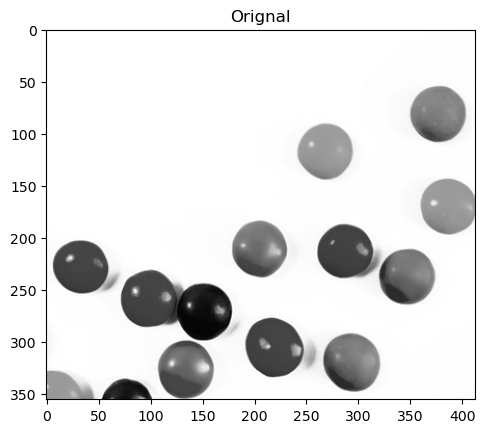

(<matplotlib.image.AxesImage at 0x122cd7f10>, Text(0.5, 1.0, 'Orignal'), None)

In [4]:
orgImg = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
plt.imshow(orgImg, 'gray'), plt.title("Orignal"), plt.show()

## Binarization
Binarizing an image is to turn pixel values into only two values (aka boolean image). There are many methods such as `compare`, `inRange`, `threshold`, `adaptiveThreshold` and `Canny` etc.

The main reason why we need binarization at the first step is to distinguish between background and foreground, where backgound is marked as 0 and foreground is marked as 255.

In this example, I use `threshold`. `THRESH_OTSU` is chosen as the threholding method for binarization. See Otsu's binarization explanation in https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html and below figure.

<img src="https://docs.opencv.org/4.x/otsu.jpg" height=300/>

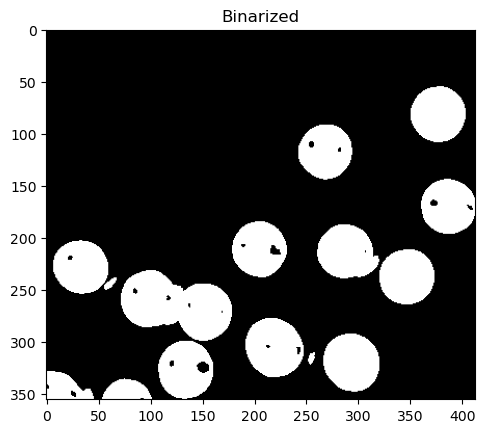

(356, 413)


In [5]:
_, thresMat = cv2.threshold(orgImg, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresMat, 'gray'), plt.title("Binarized"), plt.show()
print(thresMat.shape)

## Pre-processing
Usually, the original image is not so clean, and this leads to binary image having bad conditions, e.g. it comes with noise in background and holes in foreground etc. Therefore, processes dealing with these conditions (make it good conditioned) prior to other processes are required.

Following examples cover only noise and hole cases. There are more conditions to consider depending on your application and source of images. 

<img src="https://shrishailsgajbhar.github.io/assets/images/20210207/image0.png" height=200/>
<img src="https://shrishailsgajbhar.github.io/assets/images/20210207/mask.png" height=200/>

### Denoise
Open morphology is to reduce noise in blank space, i.e. backgournd. See https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html.

<img src="https://docs.opencv.org/4.x/opening.png" height=150/>

In [6]:
# Paremeters to adjust
openKSize = 3 # kernel size.
openIterNum = 0 # number of iteration over open morphology.

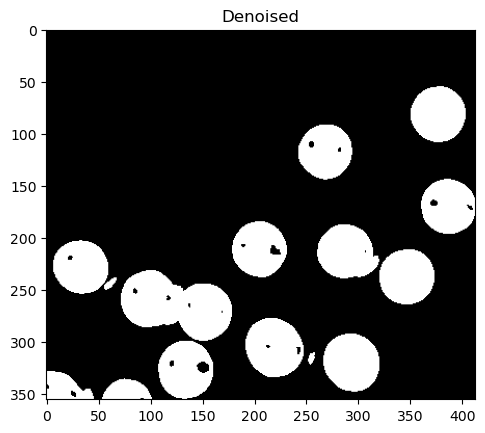

(<matplotlib.image.AxesImage at 0x122ea6610>, Text(0.5, 1.0, 'Denoised'), None)

In [7]:
k = cv2.getStructuringElement(cv2.MORPH_RECT, (openKSize,openKSize)) # kernel.
"""weight every neighbour pixel equally by
k = [ 1 1 1
      1 1 1
      1 1 1 ]
"""

openMat = cv2.morphologyEx(thresMat, cv2.MORPH_OPEN, k, iterations=openIterNum)
plt.imshow(openMat, 'gray'), plt.title("Denoised"), plt.show()

### Hole Removal
Close morphology can remove holes in foreground objects. See https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html.

<img src="https://docs.opencv.org/4.x/closing.png" height=150/>

In [8]:
# Paremeters to adjust
closeKSize = 3 # kernel size.
closeIterNum = 4 # number of iteration over close morphology.

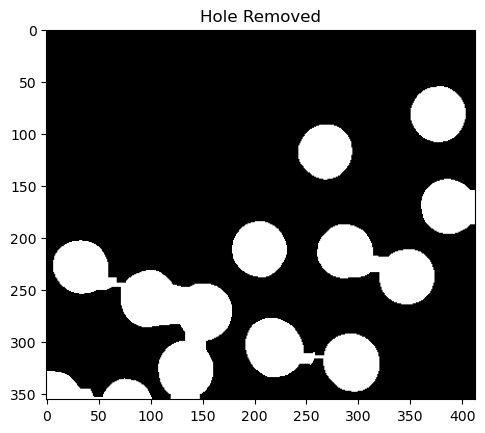

(<matplotlib.image.AxesImage at 0x122caf650>,
 Text(0.5, 1.0, 'Hole Removed'),
 None)

In [9]:
k = cv2.getStructuringElement(cv2.MORPH_RECT, (closeKSize,closeKSize)) # kernel.
"""weight every neighbour pixel equally by
k = [ 1 1 1
      1 1 1
      1 1 1 ]
"""

closeMat = cv2.morphologyEx(openMat, cv2.MORPH_CLOSE, k, iterations=closeIterNum)
plt.imshow(closeMat, 'gray'), plt.title("Hole Removed"), plt.show()

## Certain Region Identification
Althrough binary image is satisfied as desired conditions in the previos processes, binarization might be not perfect. Marginal area, i.e. boundary among background and foreground, might be inaccurate. 

<img src="https://i0.wp.com/www.franksworld.com/wp-content/uploads/2020/09/maskrcnn_grabcut_initial_segmentation.png?w=700&ssl=1" height=350/>

To address this problem, we can shrink background and foreground regions. This makes them smaller but sure. We leave the remaining area (boundary) among them as unknown region, and figure it out in the later process.


### True Background
Shrink background by enlarging foreground using `dilate` (see https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html), i.e. increase 255 (foreground) area, to make sure that the remaining 0 (background) area is the true background.

<img src="https://docs.opencv.org/4.x/j.png" height=150/>
<img src="https://docs.opencv.org/4.x/dilation.png" height=150/>

In [10]:
# Paremeters to adjust
dilKSize = 3 # kernel size.
dilIterNum = 4 # number of iteration over dilate.

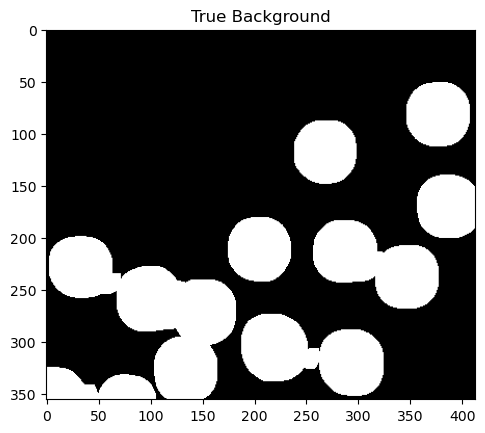

(<matplotlib.image.AxesImage at 0x122f68bd0>,
 Text(0.5, 1.0, 'True Background'),
 None)

In [11]:
k = cv2.getStructuringElement(cv2.MORPH_RECT, (dilKSize,dilKSize)) # kernel.
"""weight every neighbour pixel equally by
k = [ 1 1 1
      1 1 1
      1 1 1 ]
"""

bgMat = cv2.dilate(closeMat, k, iterations=dilIterNum)
plt.imshow(bgMat, 'gray'), plt.title("True Background"), plt.show()

### True Foreground
Shrink foreground using `erode` (see https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html), i.e. decrease 255 (foreground) area, to make sure that the remaining 255 area is the true foreground.

<img src="https://docs.opencv.org/4.x/j.png" height=150/>
<img src="https://docs.opencv.org/4.x/erosion.png" height=150/>

In [12]:
# Paremeters to adjust
erodKSize = 3 # kernel size.
erodIterNum = 4 # number of iteration over erode.

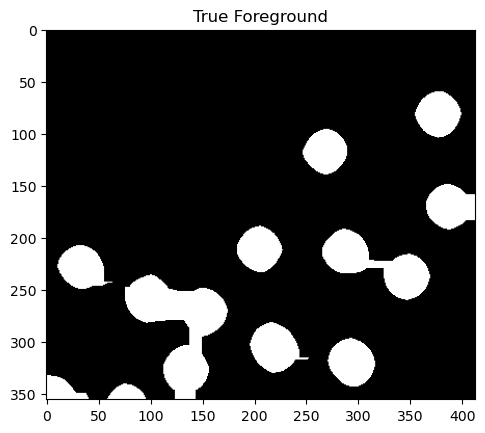

(<matplotlib.image.AxesImage at 0x122fcd990>,
 Text(0.5, 1.0, 'True Foreground'),
 None)

In [13]:
k = cv2.getStructuringElement(cv2.MORPH_RECT, (erodKSize,erodKSize)) # kernel.
"""weight every neighbour pixel equally by
k = [ 1 1 1
      1 1 1
      1 1 1 ]
"""

fgMat = cv2.erode(closeMat, k, iterations=erodIterNum)
plt.imshow(fgMat, 'gray'), plt.title("True Foreground"), plt.show()

### What If Foreground Objects Touch Each Other?
In that case, find the distance map between objects using `distanceTransform` following by `threshold` at a distance criteria to separate objects from each other. As the results, we get true foreground where objects are discriminated.

<img src="https://docs.opencv.org/4.x/water_thresh.jpg" height=200/>
<img src="https://docs.opencv.org/4.x/water_dt.jpg" height=200/>

In [14]:
# Paremeters to adjust
distRatio = 0.7 # Distance ratio between objects as threshold to separate them.

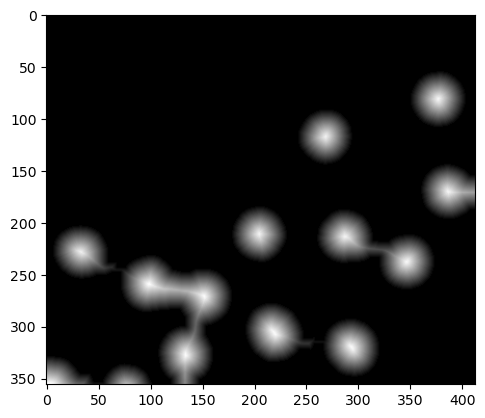

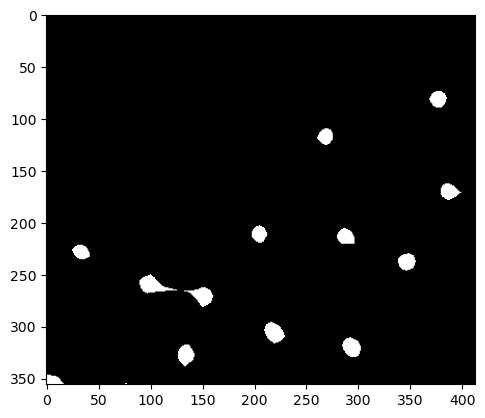

(<matplotlib.image.AxesImage at 0x1238f0650>, None)

In [15]:
distTransform = cv2.distanceTransform(closeMat, cv2.DIST_L2,5)
ret, fgMat = cv2.threshold(distTransform, distRatio*distTransform.max(), 255, 0)
fgMat = fgMat.astype(np.uint8)
plt.imshow(distTransform, 'gray'), plt.show()
plt.imshow(fgMat, 'gray'), plt.show()

### Unknown Region
Area between true foreground and true background is unknown. We can estimate the border later using `watershed`.

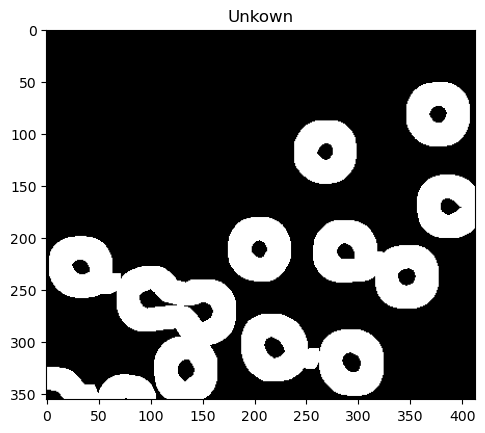

(<matplotlib.image.AxesImage at 0x12396a410>, Text(0.5, 1.0, 'Unkown'), None)

In [16]:
unkMat = cv2.subtract(bgMat, fgMat)
plt.imshow(unkMat, 'gray'), plt.title("Unkown"), plt.show()

## Markers
I use 3 alternative methods:
1. 3-regions markers composing of foreground, background and unknown without other components
2. connected components to find components/objects from their continuous area
3. contours to find components/objects from thier borders

Final marker will label each pixel with one of following values:
- 0 = unknown
- 1 = background
- more than 1 = foreground where connected components and contours can tell different objects in foreground through different label numbers.

***Remark** marker must be int32*

<img src="https://docs.opencv.org/4.x/water_marker.jpg" height=300/>

### 3 Regions

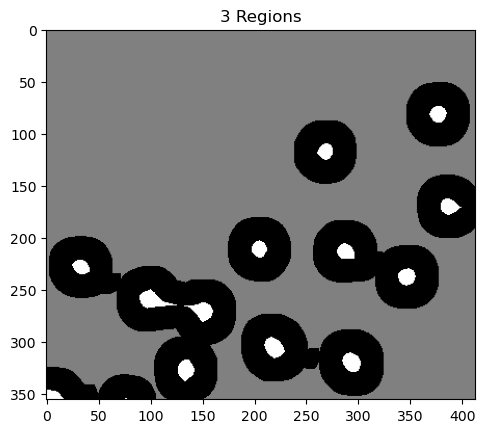

(<matplotlib.image.AxesImage at 0x1239de390>,
 Text(0.5, 1.0, '3 Regions'),
 None)

In [17]:
markers = np.zeros(fgMat.shape, np.int32)
markers[fgMat==255] = 2
markers[bgMat==0] = 1
plt.imshow(markers, 'gray'), plt.title("3 Regions"), plt.show()

### Connected Components
See https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gaedef8c7340499ca391d459122e51bef5.

Find 15 connected components.


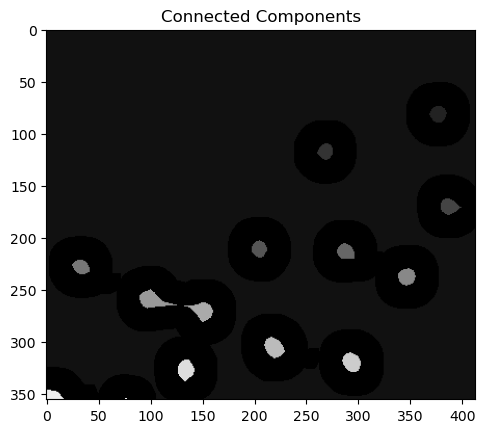

(<matplotlib.image.AxesImage at 0x123a60650>,
 Text(0.5, 1.0, 'Connected Components'),
 None)

In [18]:
componentNum, markers = cv2.connectedComponents(fgMat)
# Return number of component and mark component numbers as labels 0,1,..n-1 over image where 0 is background.
print("Find", componentNum, "connected components.") # Including background.

# Add one to all labels so background will be 1, and let unknown area be 0.
markers = markers + 1

markers[unkMat==255] = 0 # Add 0 as unknown.

plt.imshow(markers, 'gray'), plt.title("Connected Components"), plt.show()

### Contours
See https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html.

Find 13 contours.


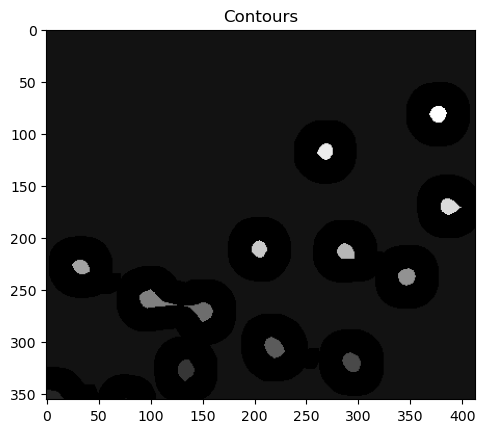

(<matplotlib.image.AxesImage at 0x123aed1d0>, Text(0.5, 1.0, 'Contours'), None)

In [19]:
contours, hierarchy = cv2.findContours(fgMat, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Remove image frame's contour.
contours = contours[1:]
hierarchy = hierarchy[1:]

print("Find", len(contours), "contours.") # excluding background.

markers = np.ones(closeMat.shape, np.int32)
for i in range(len(contours)):
    markers = cv2.drawContours(markers, contours, i, i+2, cv2.FILLED, cv2.LINE_8, hierarchy, cv2.INTER_MAX)
    
markers[unkMat==255] = 0 # add 0 as unknown.

plt.imshow(markers, 'gray'), plt.title("Contours"), plt.show()

## Watershed
Watershed will estimate border from given markers (must include unknown region labelled). See https://docs.opencv.org/4.x/d3/d47/group__imgproc__segmentation.html#ga3267243e4d3f95165d55a618c65ac6e1.

Finally, we get the marker-based segementation where unknown region (not sure where boundary is) turns into certain border, and all components are labelled: border, background, foreground and its objects.

<img src="https://docs.opencv.org/4.x/water_result.jpg" height=200/>

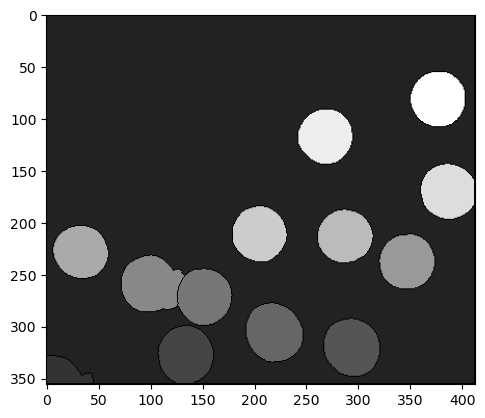

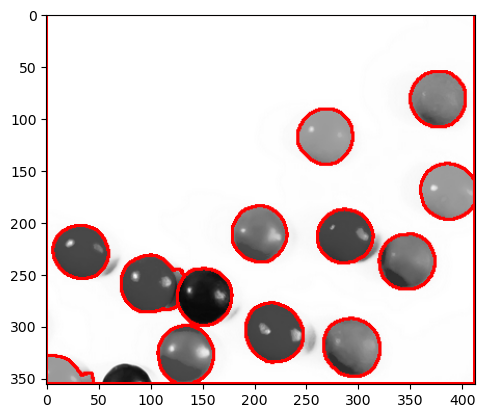

(<matplotlib.image.AxesImage at 0x123bcda10>, None)

In [20]:
colorImg = cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB)

markers = cv2.watershed(colorImg, markers)
# The boundary region will be marked with -1.
plt.imshow(markers, 'gray'), plt.show()

# Thinken boundary for clear visualization.
borderMat = np.zeros(markers.shape)
borderMat[markers==-1] = 255
k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
borderMat = cv2.dilate(borderMat, k, iterations=1)

# Turn boundary into red.
colorImg[borderMat == 255] = [255,0,0]
plt.imshow(colorImg), plt.show()